**This is a continuation of the One Author Advanced Project, where I will be "manually" cross validating and grid searching in order to find an optimal model and confirm the results of the "One_Author_Advanced" notebook**

In [1]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, precision_score, f1_score
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import itertools
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, MinMaxScaler
from statistics import mean
from scipy.sparse import hstack, csr_matrix

Reading in the dataset used in the One_Author_advanced notebook

In [2]:
df = pd.read_csv('E:/OtherCodeProjects/Springboard Capstone Projects/Springboard-Capstone-1-Data/one_author_advanced_data.csv')

df.head()

,year,paper_text,paper_id,title_len,paper_len,avg_word_len,Oral,Poster,Spotlight,Unknown,is_bernhard
0,2016,Consistent Kernel Mean Estimation\nfor Functio...,6545,67,33747,4.488406,0,1,0,0,1
1,2008,Bayesian Experimental Design of Magnetic\nReso...,3558,68,33280,4.916890,0,0,0,1,1
2,1998,Kernel peA and De-Noising in Feature Spaces\n\...,1491,43,22127,4.798472,0,0,0,1,1
3,1998,Semiparametric Support Vector and\nLinear Prog...,1575,61,18571,4.874520,0,0,0,1,1
4,2016,Minimax Estimation of Maximum Mean Discrepancy...,6483,66,29683,3.954461,0,1,0,0,1


Setting up X (features) and y (target feature)

In [3]:
exclude = ['paper_id', 'is_bernhard']
X = df[df.columns.difference(exclude)]

y = df['is_bernhard'].values.flatten()

Scaling the other features so they are usable by the model

In [4]:
scaled_feat = X[X.columns.difference(['paper_text'])]
paper_text = pd.DataFrame(X.paper_text)

minmax = MinMaxScaler()
scaled_feat = pd.DataFrame(minmax.fit_transform(scaled_feat), columns=scaled_feat.columns)
X = scaled_feat.join(paper_text)
X

,Oral,Poster,Spotlight,Unknown,avg_word_len,paper_len,title_len,year,paper_text
0,0.0,1.0,0.0,0.0,0.409777,0.271676,0.410596,0.966667,Consistent Kernel Mean Estimation\nfor Functio...
1,0.0,0.0,0.0,1.0,0.477693,0.267896,0.417219,0.700000,Bayesian Experimental Design of Magnetic\nReso...
2,0.0,0.0,0.0,1.0,0.458923,0.177621,0.251656,0.366667,Kernel peA and De-Noising in Feature Spaces\n\...
3,0.0,0.0,0.0,1.0,0.470977,0.148838,0.370861,0.366667,Semiparametric Support Vector and\nLinear Prog...
4,0.0,1.0,0.0,0.0,0.325145,0.238781,0.403974,0.966667,Minimax Estimation of Maximum Mean Discrepancy...
...,...,...,...,...,...,...,...,...,...
7234,0.0,0.0,0.0,1.0,0.422588,0.281098,0.437086,0.700000,Linear Classification and Selective Sampling\n...
7235,0.0,0.0,0.0,1.0,0.510911,0.126619,0.324503,0.100000,Generalization Dynamics in\nLMS Trained Linear...
7236,0.0,0.0,0.0,1.0,0.436957,0.254209,0.430464,0.700000,MAS: a multiplicative approximation scheme for...
7237,0.0,0.0,0.0,1.0,0.443642,0.264076,0.198675,0.700000,Clustering via LP-based Stabilities\n\nNikos K...


**Testing Tfidf hyperparameters**

In order to check if stop words have an impact on the final model I have set up a large for loop that contains the Tfidf vectorizer and a basic logistic regression model. The default 'english' stop word set was tested agains no stop words, and the results cross validated five times across five random states for the train_test split. The final results for each model are then averaged together and saved in a dictionary.

In [5]:
Tfidf_stop_words = [None, 'english']

In [6]:
random_states = [0, 1, 2, 3, 4]

In [7]:
# Initializing a dictionary with keys corresponding to the hyperparameters I am testing, 
# as well as my results on the train and test sets
LR_dict = {'Tfidf_Stop_Words': [],
            'avg_Train_auc': [],
            'avg_Test_auc': []}

run = 0
for stop_word in Tfidf_stop_words:

    # Appending the parameters for this run to my dictionary
    LR_dict['Tfidf_Stop_Words'].append(str(stop_word))

    auc_train_scores = []
    auc_test_scores = []
    for random_state in random_states:

        # Counting what iteration I am on
        print(run)
        run += 1

        # Initializing the TfidfVectorizer with different stop words, then .fit_transforming it on the train set
        # and .transforming on the test set
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random_state, train_size=0.75, stratify=y)

        other_features_train = csr_matrix(X_train[X_train.columns.difference(['paper_text'])].values)
        other_features_test = csr_matrix(X_test[X_test.columns.difference(['paper_text'])].values)

        tfidf = TfidfVectorizer(stop_words=stop_word)

        X_train_vector = tfidf.fit_transform(X_train.paper_text)
        X_test_vector = tfidf.transform(X_test.paper_text)

        X_train_tfidf = hstack([other_features_train, X_train_vector])
        X_test_tfidf = hstack([other_features_test, X_test_vector])

        # Making a pipeline with the logistic regressor inside, the C hyperparameter is chosen here
        pipe = Pipeline(steps=[
            ('LR', LogisticRegression(class_weight='balanced', C=1, max_iter=1000)),
            
        ])

        # Fitting the pipeline to the train set and predicting on both train and test sets
        pipe.fit(X_train_tfidf, y_train)
        pipe_train_pred = pipe.predict(X_train_tfidf)
        pipe_test_pred = pipe.predict(X_test_tfidf)

        # Finding the roc_auc_score for both
        auc_train = roc_auc_score(y_train, pipe_train_pred)
        auc_test = roc_auc_score(y_test, pipe_test_pred)

        #Appending the scores to the list outside the loop
        auc_train_scores.append(auc_train)
        auc_test_scores.append(auc_test)

    # Appending the scores to the dictionary
    LR_dict['avg_Train_auc'].append(mean(auc_train_scores))
    LR_dict['avg_Test_auc'].append(mean(auc_test_scores))

0
1
2
3
4
5
6
7
8
9


Using Tfidf inside the loop is time consuming, so I will recreate the above code without the TfidfVectorizer in the loop to test other models. Using no stop words gives better results across the models, so that is what I will use from here.

In [8]:
tfidf_HPtable = pd.DataFrame.from_dict(LR_dict) 
tfidf_HPtable.sort_values(by='avg_Test_auc', ascending=False, inplace=True)
tfidf_HPtable

,Tfidf_Stop_Words,avg_Train_auc,avg_Test_auc
0,None,0.994798,0.749282
1,english,0.996991,0.726233


The X_train and X_test I will use to test three seperate models and their hyperparameters. 

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=16, train_size=0.75, stratify=y)

other_features_train = csr_matrix(X_train[X_train.columns.difference(['paper_text'])].values)
other_features_test = csr_matrix(X_test[X_test.columns.difference(['paper_text'])].values)

tfidf = TfidfVectorizer()

X_train_vector = tfidf.fit_transform(X_train.paper_text)
X_test_vector = tfidf.transform(X_test.paper_text)

X_train = hstack([other_features_train, X_train_vector])
X_test = hstack([other_features_test, X_test_vector])

I will first test the LogisticRegression model, with the regularization parameter (C) and the sampling of the features as my hyperparameters. I chose a range of C values from 1 down to 0.001; and the sampling being none (using class weights instead), random oversampling, and random undersampling. 

In [10]:
C = [1, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001]

In [11]:
samplers = ['None', 'ros', 'rus']

In [12]:
hyperparameters = list(itertools.product(
                        C, samplers
))

hyperparameters

[(1, 'None'),
 (1, 'ros'),
 (1, 'rus'),
 (0.5, 'None'),
 (0.5, 'ros'),
 (0.5, 'rus'),
 (0.1, 'None'),
 (0.1, 'ros'),
 (0.1, 'rus'),
 (0.05, 'None'),
 (0.05, 'ros'),
 (0.05, 'rus'),
 (0.01, 'None'),
 (0.01, 'ros'),
 (0.01, 'rus'),
 (0.005, 'None'),
 (0.005, 'ros'),
 (0.005, 'rus'),
 (0.001, 'None'),
 (0.001, 'ros'),
 (0.001, 'rus')]

This test uses the block of code from the Tfidf test, but modified so that it tracks the F1_score and precision as well as the roc_auc, and saves the best model for each. Precision minimizes false positives, while F1_score balances between precision and recall (which minimizes false negatives). For all subsequent models I will need to choose a consistent metric to score on, and this will show me what optimizing for a particular metric looks like.

In [13]:
# Initializing a dictionary with keys corresponding to the hyperparameters I am testing, 
# as well as my results on the train and test sets
LR_dict = {'LogReg_C_value' : [],
            'Sampler': [],
            'Precision': [],
            'F1_score': [],
            'Train_auc': [],
            'Test_auc': []}

run = 0
best_score_precision = 0
best_LR_model_precision = None
best_score_F1 = 0
best_LR_model_F1 = None
best_score_auc = 0
best_LR_model_auc = None

for C_value, sampler_type in hyperparameters:

    # Counting what iteration I am on
    print(run)
    run += 1
    
    # Appending the parameters for this run to my dictionary
    LR_dict['LogReg_C_value'].append(C_value)
    LR_dict['Sampler'].append(sampler_type)

    # Making pipelines for each sampler type, with the C value used within
    if sampler_type == 'rus':
        pipe = Pipeline(steps=[
            ('rus', RandomUnderSampler(random_state=21)),
            ('LR', LogisticRegression(C=C_value, max_iter=1000))
            ])

    elif sampler_type == 'ros':
        pipe = Pipeline(steps=[
            ('ros', RandomOverSampler(random_state=21)),
            ('LR', LogisticRegression(C=C_value, max_iter=1000))
            ])

    else:
        pipe = Pipeline(steps=[
            ('LR', LogisticRegression(class_weight='balanced', C=C_value, max_iter=1000))
            ])

    # Fitting the pipeline to the train set and predicting on both train and test sets
    pipe.fit(X_train, y_train)
    pipe_train_pred = pipe.predict(X_train)
    pipe_test_pred = pipe.predict(X_test)

    # Finding the roc_auc_score for both, I am including precision as in the past 
    # undersampling has led to awful precision scores
    precision = precision_score(y_test, pipe_test_pred)
    F1_score = f1_score(y_test, pipe_test_pred)
    auc_train = roc_auc_score(y_train, pipe_train_pred)
    auc_test = roc_auc_score(y_test, pipe_test_pred)

    # Appending the scores to the dictionary
    LR_dict['Precision'].append(precision)
    LR_dict['F1_score'].append(F1_score)
    LR_dict['Train_auc'].append(auc_train)
    LR_dict['Test_auc'].append(auc_test)

    # Saving the best model
    if precision > best_score_precision:
        best_score_precision = precision
        best_LR_model_precision = pipe

    if F1_score > best_score_F1:
        best_score_F1 = F1_score
        best_LR_model_F1 = pipe

    if auc_test > best_score_auc:
        best_score_auc = auc_test
        best_LR_model_auc = pipe

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


The full hyperparameter table for the LogisticRegression test.

In [14]:
LR_HPtable = pd.DataFrame.from_dict(LR_dict) 
LR_HPtable.sort_values(by='F1_score', ascending=False, inplace=True)
LR_HPtable

,LogReg_C_value,Sampler,Precision,F1_score,Train_auc,Test_auc
1,1.000,ros,0.363636,0.421053,0.996470,0.746098
0,1.000,None,0.333333,0.418605,0.994334,0.776233
4,0.500,ros,0.310345,0.400000,0.994148,0.775676
3,0.500,None,0.250000,0.357143,0.990804,0.804139
7,0.100,ros,0.144928,0.235294,0.986346,0.796056
10,0.050,ros,0.102041,0.175439,0.968789,0.787974
6,0.100,None,0.101010,0.173913,0.968696,0.787695
9,0.050,None,0.056497,0.103627,0.938599,0.765956
2,1.000,rus,0.030806,0.059361,0.860109,0.792259
13,0.010,ros,0.030220,0.057895,0.867259,0.745366


Optimizing for precision gets a model that has a very low number (relatively) of false positives. In this case it produced the same model as optimizing for F1_score. However, in other tests it might be too conservative a metric.

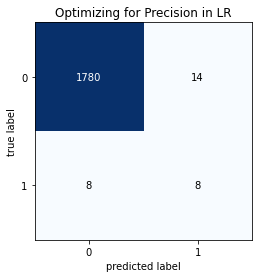

In [15]:
best_LR_model_precision.fit(X_train, y_train)
best_LR_pred = best_LR_model_precision.predict(X_test)
best_LR_cm_test = confusion_matrix(y_test, best_LR_pred)
fig, ax = plot_confusion_matrix(conf_mat=best_LR_cm_test)
plt.title('Optimizing for Precision in LR')
plt.show()

Optimizing for F1_score makes a model that balances between precision (fewer false positives) and recall (fewer false negatives).

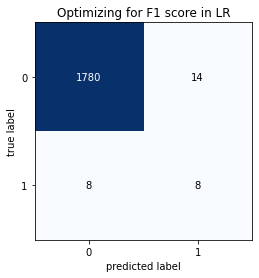

In [16]:
best_LR_model_F1.fit(X_train, y_train)
best_LR_pred = best_LR_model_F1.predict(X_test)
best_LR_cm_test = confusion_matrix(y_test, best_LR_pred)
fig, ax = plot_confusion_matrix(conf_mat=best_LR_cm_test)
plt.title('Optimizing for F1 score in LR')
plt.show()

predicting for roc_auc in this case produces a model that predicts two more papers but also greatly increases the false positive rate. This is probably too aggressive a metric.

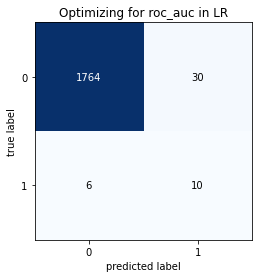

In [17]:
best_LR_model_auc.fit(X_train, y_train)
best_LR_pred = best_LR_model_auc.predict(X_test)
best_LR_cm_test = confusion_matrix(y_test, best_LR_pred)
fig, ax = plot_confusion_matrix(conf_mat=best_LR_cm_test)
plt.title('Optimizing for roc_auc in LR')
plt.show()

I will use F1 score (2 * (precision * recall) / (precision + recall)) for the following models

Now I will test the LinearSVC model, as SVC took too long to train. I am testing the same hyperparameters (C and the three different samplers) as I was with the LogisticRegression.

In [18]:
C = [1, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001]

In [19]:
samplers = ['None', 'ros', 'rus']

In [20]:
hyperparameters = list(itertools.product(
                        C, samplers
))

hyperparameters

[(1, 'None'),
 (1, 'ros'),
 (1, 'rus'),
 (0.5, 'None'),
 (0.5, 'ros'),
 (0.5, 'rus'),
 (0.1, 'None'),
 (0.1, 'ros'),
 (0.1, 'rus'),
 (0.05, 'None'),
 (0.05, 'ros'),
 (0.05, 'rus'),
 (0.01, 'None'),
 (0.01, 'ros'),
 (0.01, 'rus'),
 (0.005, 'None'),
 (0.005, 'ros'),
 (0.005, 'rus'),
 (0.001, 'None'),
 (0.001, 'ros'),
 (0.001, 'rus')]

In [21]:
# Initializing a dictionary with keys corresponding to the hyperparameters I am testing, 
# as well as my results on the train and test sets
SVC_dict = {'SVC_C_value' : [],
            'Sampler': [],
            'F1_score_train': [],
            'F1_score_test': []}

run = 0
best_score_F1 = 0
best_SVC_model = None

for C_value, sampler_type in hyperparameters:

    # Counting what iteration I am on
    print(run)
    run += 1
    
    # Appending the parameters for this run to my dictionary
    SVC_dict['SVC_C_value'].append(C_value)
    SVC_dict['Sampler'].append(sampler_type)

    # Making pipelines for each sampler type, with the C value used within
    if sampler_type == 'rus':
        pipe = Pipeline(steps=[
            ('rus', RandomUnderSampler(random_state=21)),
            ('SVC', LinearSVC(C=C_value))
            ])

    elif sampler_type == 'ros':
        pipe = Pipeline(steps=[
            ('ros', RandomOverSampler(random_state=21)),
            ('SVC', LinearSVC(C=C_value))
            ])

    else:
        pipe = Pipeline(steps=[
            ('SVC', LinearSVC(class_weight='balanced', C=C_value))
            ])

    # Fitting the pipeline to the train set and predicting on both train and test sets
    pipe.fit(X_train, y_train)
    pipe_train_pred = pipe.predict(X_train)
    pipe_test_pred = pipe.predict(X_test)

    # Finding the roc_auc_score for both, I am including precision as in the past 
    # undersampling has led to awful precision scores
    F1_score_train = f1_score(y_train, pipe_train_pred)
    F1_score_test = f1_score(y_test, pipe_test_pred)

    # Appending the scores to the dictionary
    SVC_dict['F1_score_train'].append(F1_score_train)
    SVC_dict['F1_score_test'].append(F1_score_test)


    # Saving the best model
    if F1_score_test > best_score_F1:
        best_score_F1 = F1_score_test
        best_SVC_model = pipe

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


The hyperparameter table for the SVC model. Overall it looks pretty similar to the logistic regression model.

In [22]:
SVC_HPtable = pd.DataFrame.from_dict(SVC_dict) 
SVC_HPtable.sort_values(by='F1_score_test', ascending=False, inplace=True)
SVC_HPtable

,SVC_C_value,Sampler,F1_score_train,F1_score_test
7,0.100,ros,0.844037,0.484848
6,0.100,None,0.671533,0.473684
10,0.050,ros,0.671533,0.461538
1,1.000,ros,0.989247,0.454545
0,1.000,None,0.958333,0.454545
4,0.500,ros,0.958333,0.454545
3,0.500,None,0.920000,0.416667
9,0.050,None,0.519774,0.377358
13,0.010,ros,0.396552,0.250000
16,0.005,ros,0.298013,0.180180


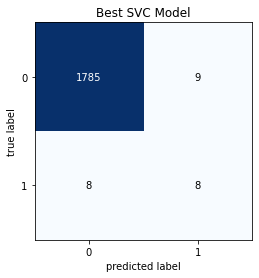

In [23]:
best_SVC_model.fit(X_train, y_train)
best_SVC_pred = best_SVC_model.predict(X_test)
best_SVC_cm_test = confusion_matrix(y_test, best_SVC_pred)
fig, ax = plot_confusion_matrix(conf_mat=best_SVC_cm_test)
plt.title('Best SVC Model')
plt.show()

Now I'm testing a Random Forest Classifier. Here the hyperparameters are n_estimators (the number of 'trees' in the forest), and the same samplers as before. 

In [24]:
n_estimators = [int(n) for n in np.logspace(start=2, stop=3, num=5)]

In [25]:
samplers = ['None', 'ros', 'rus']

In [26]:
hyperparameters = list(itertools.product(
                        n_estimators, samplers
))

hyperparameters

[(100, 'None'),
 (100, 'ros'),
 (100, 'rus'),
 (177, 'None'),
 (177, 'ros'),
 (177, 'rus'),
 (316, 'None'),
 (316, 'ros'),
 (316, 'rus'),
 (562, 'None'),
 (562, 'ros'),
 (562, 'rus'),
 (1000, 'None'),
 (1000, 'ros'),
 (1000, 'rus')]

In [27]:
# Initializing a dictionary with keys corresponding to the hyperparameters I am testing, 
# as well as my results on the train and test sets
RFC_dict = {'n_estimators': [],
            'Sampler': [],
            'F1_score_train': [],
            'F1_score_test': []}

run = 0
best_score_F1 = 0
best_RFC_model = None

for n_estimator, sampler_type in hyperparameters:

    # Counting what iteration I am on
    print(run)
    run += 1
    
    # Appending the parameters for this run to my dictionary
    RFC_dict['Sampler'].append(sampler_type)
    RFC_dict['n_estimators'].append(n_estimator)

    # Making pipelines for each sampler type, with the n_estimator value used within
    if sampler_type == 'rus':
        pipe = Pipeline(steps=[
            ('rus', RandomUnderSampler(random_state=21)),
            ('RFC', RandomForestClassifier(n_estimators=n_estimator, max_leaf_nodes=2000, min_samples_leaf=3, max_depth=50))
            ])

    elif sampler_type == 'ros':
        pipe = Pipeline(steps=[
            ('ros', RandomOverSampler(random_state=21)),
            ('RFC', RandomForestClassifier(n_estimators=n_estimator, max_leaf_nodes=2000, min_samples_leaf=3, max_depth=50))
            ])

    else:
        pipe = Pipeline(steps=[
            ('RFC', RandomForestClassifier(n_estimators=n_estimator, class_weight="balanced_subsample", max_leaf_nodes=2000, min_samples_leaf=3))
            ])

    # Fitting the pipeline to the train set and predicting on both train and test sets
    pipe.fit(X_train, y_train)
    pipe_train_pred = pipe.predict(X_train)
    pipe_test_pred = pipe.predict(X_test)

    # Finding the roc_auc_score for both, I am including precision as in the past 
    # undersampling has led to awful precision scores
    F1_score_train = f1_score(y_train, pipe_train_pred)
    F1_score_test = f1_score(y_test, pipe_test_pred)

    # Appending the scores to the dictionary
    RFC_dict['F1_score_train'].append(F1_score_train)
    RFC_dict['F1_score_test'].append(F1_score_test)


    # Saving the best model
    if F1_score_test > best_score_F1:
        best_score_F1 = F1_score_test
        best_RFC_model = pipe

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


In [28]:
RFC_HPtable = pd.DataFrame.from_dict(RFC_dict) 
RFC_HPtable.sort_values(by='F1_score_test', ascending=False, inplace=True)
RFC_HPtable

,n_estimators,Sampler,F1_score_train,F1_score_test
8,316,rus,0.263610,0.212121
14,1000,rus,0.248649,0.190476
11,562,rus,0.246649,0.178082
5,177,rus,0.193277,0.132597
2,100,rus,0.143079,0.114286
0,100,None,1.000000,0.000000
1,100,ros,1.000000,0.000000
3,177,None,1.000000,0.000000
4,177,ros,1.000000,0.000000
6,316,None,1.000000,0.000000


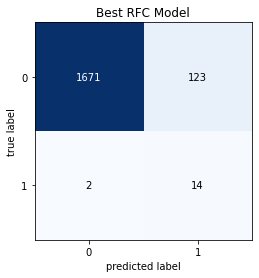

In [29]:
best_RFC_model.fit(X_train, y_train)
best_RFC_pred = best_RFC_model.predict(X_test)
best_RFC_cm_test = confusion_matrix(y_test, best_RFC_pred)
fig, ax = plot_confusion_matrix(conf_mat=best_RFC_cm_test)
plt.title('Best RFC Model')
plt.show()

**Trying truncatedSVD analysis on LR model**

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=16, train_size=0.75, stratify=y)

This paper messed with the SVD analysis, having PCA1 and PCA2 scores 100s of times higher than the others. All I can see is that it is the longest paper by ~10x and contains a lot of newlines

In [31]:
X_train.iloc[982]

Oral                                                          0.0
Poster                                                        1.0
Spotlight                                                     0.0
Unknown                                                       0.0
avg_word_len                                             0.527825
paper_len                                                0.237964
title_len                                                0.470199
year                                                     0.966667
paper_text      Learning shape correspondence with\nanisotropi...
Name: 652, dtype: object

In [32]:
new_df= df.sort_values(by='paper_len', ascending=False).head()
new_df

,year,paper_text,paper_id,title_len,paper_len,avg_word_len,Oral,Poster,Spotlight,Unknown,is_bernhard
2777,2016,Learning Multiagent Communication\nwith Backpr...,6398,54,123727,4.553913,0,1,0,0,0
1540,2013,On the Representational Efficiency of Restrict...,5020,67,67731,4.215039,0,1,0,0,0
1559,2013,A Stability-based Validation Procedure for\nDi...,5014,82,61615,4.019754,0,1,0,0,0
5989,1987,317\n\nPARTITIONING OF SENSORY DATA BY A CORTI...,44,50,58011,5.471569,0,0,0,1,0
1764,2017,A Unified Game-Theoretic Approach to\nMultiage...,7007,70,56172,5.534487,0,1,0,0,0


In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=16, train_size=0.75, stratify=y)

other_features_train = csr_matrix(X_train[X_train.columns.difference(['paper_text'])].values)
other_features_test = csr_matrix(X_test[X_test.columns.difference(['paper_text'])].values)

tfidf = TfidfVectorizer()

X_train_vector = tfidf.fit_transform(X_train.paper_text)
X_test_vector = tfidf.transform(X_test.paper_text)

X_train = hstack([other_features_train, X_train_vector])
X_test = hstack([other_features_test, X_test_vector])

In [34]:
standard_scaler = StandardScaler(with_mean=False)

X_train = standard_scaler.fit_transform(X_train)
X_test = standard_scaler.transform(X_test)

In [35]:
tSVD = TruncatedSVD(n_components=2, random_state=21)

X_train = tSVD.fit_transform(X_train)
X_test = tSVD.transform(X_test)

In [36]:
PCAdf = pd.DataFrame(data=X_train, columns = ['PC1', 'PC2'])
y_df = pd.DataFrame(data=y_train, columns=['is_bernhard'])

PCAdf = pd.concat([PCAdf, y_df], axis = 1)
PCAdf.sort_values(by='is_bernhard', ascending=True, inplace=True)
PCAdf2 = PCAdf.drop(982)
PCAdf2.sort_values(by='is_bernhard', ascending=True, inplace=True)

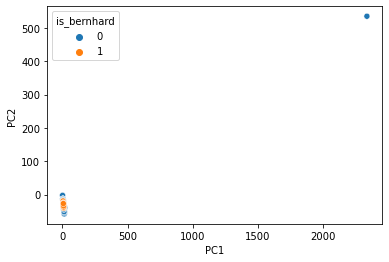

In [37]:
x_axis = PCAdf.PC1
y_axis = PCAdf.PC2

plt.subplots()
sns.scatterplot(x=x_axis, y=y_axis, hue=PCAdf.is_bernhard, data=PCAdf)
plt.show()

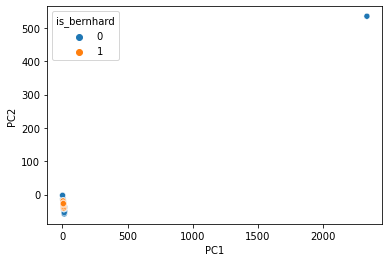

In [38]:
x_axis = PCAdf2.PC1
y_axis = PCAdf2.PC2

plt.subplots()
sns.scatterplot(x=x_axis, y=y_axis, hue=PCAdf2.is_bernhard, data=PCAdf2)
plt.show()

Seeing what TruncatedSVD does to the LR model

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=16, train_size=0.75, stratify=y)

other_features_train = csr_matrix(X_train[X_train.columns.difference(['paper_text'])].values)
other_features_test = csr_matrix(X_test[X_test.columns.difference(['paper_text'])].values)

tfidf = TfidfVectorizer()

X_train_vector = tfidf.fit_transform(X_train.paper_text)
X_test_vector = tfidf.transform(X_test.paper_text)

X_train = hstack([other_features_train, X_train_vector])
X_test = hstack([other_features_test, X_test_vector])

In [40]:
standard_scaler = StandardScaler(with_mean=False)

X_train = standard_scaler.fit_transform(X_train)
X_test = standard_scaler.transform(X_test)

In [41]:
n_components = [2, 10, 50, 100, 300, 500, 1000]

In [42]:
# Initializing a dictionary with keys corresponding to the hyperparameters I am testing, 
# as well as my results on the train and test sets
SVD_dict = {'n_components' : [],
            'F1_score_train': [],
            'F1_score_test': []}

run = 0
best_score_F1 = 0
best_SVD_model = None

for n_component in n_components:

    # Counting what iteration I am on
    print(run)
    run += 1
    
    # Appending the parameters for this run to my dictionary
    SVD_dict['n_components'].append(n_component)

    # Making pipelines for each n_component
    tSVD = TruncatedSVD(n_components=n_component)

    X_train_SVD = tSVD.fit_transform(X_train)
    X_test_SVD = tSVD.transform(X_test)

    pipe = Pipeline(steps=[
            ('LR', LogisticRegression(class_weight='balanced', C=0.5, max_iter=2000))
            ])

    # Fitting the pipeline to the train set and predicting on both train and test sets
    pipe.fit(X_train_SVD, y_train)
    pipe_train_pred = pipe.predict(X_train_SVD)
    pipe_test_pred = pipe.predict(X_test_SVD)

    # Finding the roc_auc_score for both, I am including precision as in the past 
    # undersampling has led to awful precision scores
    F1_score_train = f1_score(y_train, pipe_train_pred)
    F1_score_test = f1_score(y_test, pipe_test_pred)

    # Appending the scores to the dictionary
    SVD_dict['F1_score_train'].append(F1_score_train)
    SVD_dict['F1_score_test'].append(F1_score_test)

    # Saving the best model
    if F1_score_test > best_score_F1:
        best_score_F1 = F1_score_test
        best_SVD_model = pipe

0
1
2
3
4
5
6


In [43]:
SVD_HPtable = pd.DataFrame.from_dict(SVD_dict) 
SVD_HPtable.sort_values(by='F1_score_test', ascending=False, inplace=True)
SVD_HPtable

,n_components,F1_score_train,F1_score_test
6,1000,1.000000,0.272727
4,300,0.248649,0.212766
5,500,0.544379,0.166667
3,100,0.103165,0.088889
2,50,0.056818,0.054608
1,10,0.027003,0.028450
0,2,0.025907,0.026634


In [44]:
tSVD = TruncatedSVD(n_components=1000)

X_train_SVD = tSVD.fit_transform(X_train)
X_test_SVD = tSVD.transform(X_test)

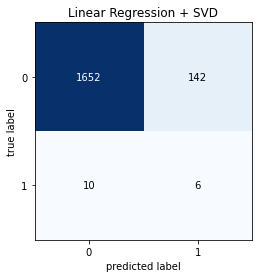

In [45]:
best_SVD_model.fit(X_train_SVD, y_train)
best_SVD_pred = best_SVD_model.predict(X_test_SVD)
SVD_test = confusion_matrix(y_test, best_SVD_pred)
fig, ax = plot_confusion_matrix(conf_mat=SVD_test)
plt.title('Linear Regression + SVD')
plt.show()

In [46]:
C = [1, 0.5, 0.1]

In [47]:
samplers = ['None', 'ros']

In [48]:
hyperparameters = list(itertools.product(
                        C, samplers
))

hyperparameters

[(1, 'None'),
 (1, 'ros'),
 (0.5, 'None'),
 (0.5, 'ros'),
 (0.1, 'None'),
 (0.1, 'ros')]

In [49]:
random_states = [0, 1, 2, 3, 4]

In [50]:
# Initializing a dictionary with keys corresponding to the hyperparameters I am testing, 
# as well as my results on the train and test sets
LR_dict_final = {'LogReg_C_value' : [],
            'Sampler': [],
            'F1_score_train_avg': [],
            'F1_score_test_avg':[]}

run = 0

for C_value, sampler_type in hyperparameters:

    # Counting what iteration I am on
    print(run)
    run += 1
    
    # Appending the parameters for this run to my dictionary
    LR_dict_final['LogReg_C_value'].append(C_value)
    LR_dict_final['Sampler'].append(sampler_type)

    F1_train_scores = []
    F1_test_scores = []
    for random_state in random_states:

        # For each random state create a new train/test split and re-TfidfVectorize
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random_state, train_size=0.75, stratify=y)

        other_features_train = csr_matrix(X_train[X_train.columns.difference(['paper_text'])].values)
        other_features_test = csr_matrix(X_test[X_test.columns.difference(['paper_text'])].values)

        tfidf = TfidfVectorizer()

        X_train_vector = tfidf.fit_transform(X_train.paper_text)
        X_test_vector = tfidf.transform(X_test.paper_text)

        X_train = hstack([other_features_train, X_train_vector])
        X_test = hstack([other_features_test, X_test_vector])

        # Making pipelines for each sampler type, with the C value used within
        if sampler_type == 'ros':
            pipe = Pipeline(steps=[
                ('ros', RandomOverSampler(random_state=21)),
                ('LR', LogisticRegression(C=C_value, max_iter = 1000))
                ])

        else:
            pipe = Pipeline(steps=[
                ('LR', LogisticRegression(class_weight='balanced', C=C_value, max_iter = 1000))
                ])

        # Fitting the pipeline to the train set and predicting on both train and test sets
        pipe.fit(X_train, y_train)
        pipe_train_pred = pipe.predict(X_train)
        pipe_test_pred = pipe.predict(X_test)

        # Finding the roc_auc_score for both, I am including precision as in the past 
        # undersampling has led to awful precision scores
        F1_score_train = f1_score(y_train, pipe_train_pred)
        F1_score_test = f1_score(y_test, pipe_test_pred)

        #Appending the scores to the list outside the loop
        F1_train_scores.append(F1_score_train)
        F1_test_scores.append(F1_score_test)
        
    # Appending the scores to the dictionary
    LR_dict_final['F1_score_train_avg'].append(mean(F1_train_scores))
    LR_dict_final['F1_score_test_avg'].append(mean(F1_test_scores))


0
1
2
3
4
5


In [51]:
LR_final_HPtable = pd.DataFrame.from_dict(LR_dict_final) 
LR_final_HPtable.sort_values(by='F1_score_test_avg', ascending=False, inplace=True)
LR_final_HPtable

,LogReg_C_value,Sampler,F1_score_train_avg,F1_score_test_avg
1,1.0,ros,0.736420,0.400422
3,0.5,ros,0.618118,0.342637
0,1.0,None,0.622429,0.335779
2,0.5,None,0.516402,0.292493
5,0.1,ros,0.395816,0.239398
4,0.1,None,0.312448,0.198353


Cross validating the SVC model

In [56]:
C = [1, 0.5, 0.1, 0.05]

In [57]:
samplers = ['None', 'ros']

In [58]:
hyperparameters = list(itertools.product(
                        C, samplers
))

hyperparameters

[(1, 'None'),
 (1, 'ros'),
 (0.5, 'None'),
 (0.5, 'ros'),
 (0.1, 'None'),
 (0.1, 'ros'),
 (0.05, 'None'),
 (0.05, 'ros')]

In [59]:
# Initializing a dictionary with keys corresponding to the hyperparameters I am testing, 
# as well as my results on the train and test sets
SVC_dict_final = {'SVC_C_value' : [],
            'Sampler': [],
            'F1_score_train_avg': [],
            'F1_score_test_avg':[]}

run = 0

for C_value, sampler_type in hyperparameters:

    # Counting what iteration I am on
    print(run)
    run += 1
    
    # Appending the parameters for this run to my dictionary
    SVC_dict_final['SVC_C_value'].append(C_value)
    SVC_dict_final['Sampler'].append(sampler_type)

    F1_train_scores = []
    F1_test_scores = []
    for random_state in random_states:

        # For each random state create a new train/test split and re-TfidfVectorize
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random_state, train_size=0.75, stratify=y)

        other_features_train = csr_matrix(X_train[X_train.columns.difference(['paper_text'])].values)
        other_features_test = csr_matrix(X_test[X_test.columns.difference(['paper_text'])].values)

        tfidf = TfidfVectorizer()

        X_train_vector = tfidf.fit_transform(X_train.paper_text)
        X_test_vector = tfidf.transform(X_test.paper_text)

        X_train = hstack([other_features_train, X_train_vector])
        X_test = hstack([other_features_test, X_test_vector])

        # Making pipelines for each sampler type, with the C value used within
        if sampler_type == 'ros':
            pipe = Pipeline(steps=[
                ('ros', RandomOverSampler(random_state=21)),
                ('SVC', LinearSVC(C=C_value))
                ])

        else:
            pipe = Pipeline(steps=[
                ('SVC', LinearSVC(class_weight='balanced', C=C_value, max_iter = 1000))
                ])

        # Fitting the pipeline to the train set and predicting on both train and test sets
        pipe.fit(X_train, y_train)
        pipe_train_pred = pipe.predict(X_train)
        pipe_test_pred = pipe.predict(X_test)

        # Finding the roc_auc_score for both, I am including precision as in the past 
        # undersampling has led to awful precision scores
        F1_score_train = f1_score(y_train, pipe_train_pred)
        F1_score_test = f1_score(y_test, pipe_test_pred)

        #Appending the scores to the list outside the loop
        F1_train_scores.append(F1_score_train)
        F1_test_scores.append(F1_score_test)
        
    # Appending the scores to the dictionary
    SVC_dict_final['F1_score_train_avg'].append(mean(F1_train_scores))
    SVC_dict_final['F1_score_test_avg'].append(mean(F1_test_scores))

0
1
2
3
4
5
6
7


In [60]:
SVC_final_HPtable = pd.DataFrame.from_dict(SVC_dict_final) 
SVC_final_HPtable.sort_values(by='F1_score_test_avg', ascending=False, inplace=True)
SVC_final_HPtable

,SVC_C_value,Sampler,F1_score_train_avg,F1_score_test_avg
2,0.50,None,0.937070,0.465373
5,0.10,ros,0.817270,0.439944
0,1.00,None,0.983023,0.436330
3,0.50,ros,0.980872,0.436330
4,0.10,None,0.676678,0.393547
7,0.05,ros,0.674759,0.391808
1,1.00,ros,0.995699,0.374433
6,0.05,None,0.539322,0.324028


Checking feature importance in optimal pipeline

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=16, train_size=0.75, stratify=y)

other_features_train = csr_matrix(X_train[X_train.columns.difference(['paper_text'])].values)
other_features_test = csr_matrix(X_test[X_test.columns.difference(['paper_text'])].values)

tfidf = TfidfVectorizer(stop_words=None)

X_train_vector = tfidf.fit_transform(X_train.paper_text)
X_test_vector = tfidf.transform(X_test.paper_text)

X_train = hstack([other_features_train, X_train_vector])
X_test = hstack([other_features_test, X_test_vector])


In [62]:
pipe = Pipeline(steps=[
                ('SVC', LinearSVC(C=0.5, class_weight='balanced', max_iter=1000))
                ])

In [63]:
pipe.fit(X_train, y_train)
pipe_train_pred = pipe.predict(X_train)
pipe_test_pred = pipe.predict(X_test)

In [64]:
F1_score_train = f1_score(y_train, pipe_train_pred)
F1_score_test = f1_score(y_test, pipe_test_pred)
print(F1_score_train)
print(F1_score_test)

0.92
0.4166666666666667


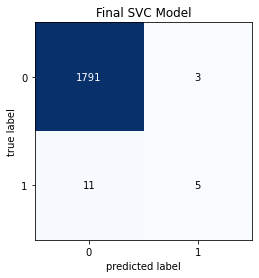

In [65]:
Final_test = confusion_matrix(y_test, pipe_test_pred)
fig, ax = plot_confusion_matrix(conf_mat=Final_test)
plt.title('Final SVC Model')
plt.show()

In [66]:
pipe_predict_proba = pipe.predict_proba(X_test)

neg_weights = 100 * np.ones_like(pipe_predict_proba[:, 1][y_test==0]) / len(pipe_predict_proba[:, 1][y_test==0])
pos_weights = 100 * np.ones_like(pipe_predict_proba[:, 1][y_test==1]) / len(pipe_predict_proba[:, 1][y_test==1])

plt.hist(pipe_predict_proba[:, 1][y_test==0], color='Red', alpha=0.5, label='True Negatives', bins=50, weights=neg_weights)
plt.hist(pipe_predict_proba[:, 1][y_test==1], color='Blue', alpha=0.5, label='True Positives', bins=20, weights=pos_weights)
plt.xlabel('Probability of being Positive Class')
plt.ylabel('Percent of Dataset in Bin')
plt.title('Probability a Paper is Bernhard Scholkopf\'s')
plt.legend()
plt.show()

AttributeError: 'LinearSVC' object has no attribute 'predict_proba'

In [67]:
columns = ['Oral', 'Poster', 'Spotlight', 'Unknown', 'avg_word_len', 'paper_len']
for feature_name in tfidf.get_feature_names_out():
    columns.append(feature_name)
columns.append('title_len')
columns.append('year')

In [68]:
feature_imp_df = pd.DataFrame(pipe.named_steps['SVC'].coef_, columns=columns)
feature_imp_df = feature_imp_df.T.reset_index().rename(columns={0:'value', 'index':'feature'})
feature_imp_df.sort_values(by='value', ascending=False, inplace=True)
feature_imp_df

,feature,value
177684,tq1,1.637397
98262,ipglon,1.550710
165133,smola2,1.488218
91345,hypergrid,1.469599
159712,scholkopj,1.460791
...,...,...
143386,posterior3,-0.557924
78031,for111,-0.568376
55337,convexconcave,-0.626062
175929,time10,-0.643536
